## $$ H = 4E_C n_q^2 - 2E_J \cos(\phi) + \alpha E_J \cos(2\phi - \phi_{ext}) $$
## $$ E_J / E_C = 100 \quad , \quad \phi_{ext} = 0.01\pi $$
%## $$ %\rightarrow \quad H = 0.04 n_q^2 - 2 \cos(\phi) + \alpha \cos(2\phi - 0.001\pi) $$
## With $\alpha \in [0.5;1]$.. The following is in the $n_q$ basis.

## $$ e^{-i\phi} \rightarrow FT \rightarrow \sum_i |n><n+1|$$
## $$ e^{-i2\phi} \rightarrow FT \rightarrow \sum_i |n><n+2|$$

In [1]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('C:/Users/jv97/github/Quantum-Optimal-Control/scripts')

# from SimulatedAnnealing import SimulatedAnnealing, UniformSampler, GaussianSampler

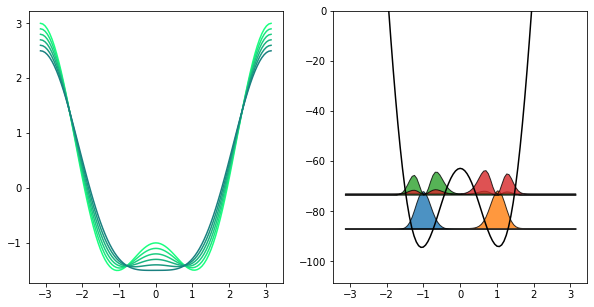

In [2]:
phi_ext = 0.001*t.pi
EJ = 2*t.pi*10 #GHz
EC = EJ/400
def plot_potential(N=101):
    phi = t.linspace(-np.pi,np.pi,N)
    fig, ax = plt.subplots(figsize=(10,5),ncols=2)
    for alpha in np.arange(1,0.4,-0.1):
        ax[0].plot(phi, -2*t.cos(phi) + alpha*t.cos(2*phi - phi_ext),c=(0.1,alpha,0.5))
    
    double_diff = (t.diag(-2*t.ones(N)) + t.diag(t.ones(N-1),1) + t.diag(t.ones(N-1),-1)).type(t.complex128)
    dphi = (phi[1:] - phi[:-1]).mean().item()
    KinE = -4*EC/dphi**2*double_diff
    V_E = -2*EJ*t.diag(t.cos(phi)) + EJ*t.diag(t.cos(2*phi - phi_ext))

    eigvals, eigvecs = t.linalg.eigh(KinE + V_E)
    eigvecs = eigvecs.T

    ax[1].plot(phi,-2*EJ*t.cos(phi) + EJ*t.cos(2*phi - phi_ext),'k')
    indices = [0,1,2,3]
    for i in indices:
        ax[1].fill_between(phi,t.abs(eigvecs[i])**2*2*EJ+eigvals[i],eigvals[i],label='n=%d'%i,edgecolor='k',alpha=0.8)
    ax[1].set_ylim(None,0)
    return #eigvals[:21]

plot_potential(N=101)

- I have checked that is is in agreeance with the flux basis, and that you need higher resolution for the flux basis to achieve the same precision that the charge basis gets with lower resolution.

- I have also checked that to change between the two simply seems to be a dfft, ie. ( ft = t.fft.ifft(eigvecs\[0\])*np.sqrt(N) to go from charge to flux ) except that the ordering of 'ft' is now \[0,..,+max_freq,-max_freq,...,-0.001\] (see torch.fft.fftshift docs)

Right now the dimensions of the derivatives are not correct.


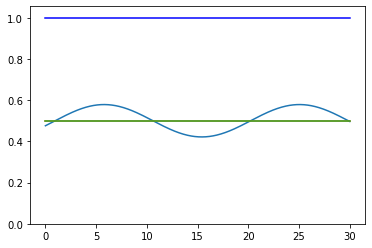

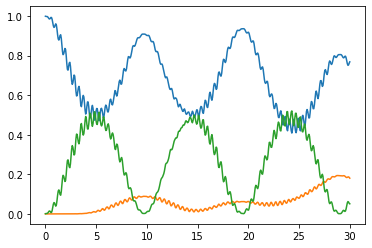

In [621]:
import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls

importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)

params_dict = {
    'T': 30,
    'NTrot': 500,
    'q_max': 10,
    'lr': 1e-2,
    'Scheduler': False,
}

systems_dict = {
    'phi_ext': phi_ext,
    'EJ': EJ,
    'EC': EC
}

init_dict = {
    'decline_end':4.8758,
    'ascend_start':25.0227,
    'level':0.8904,
    'envelope_amp':0.1262,
    'detuning':0.9872,
    'phase':0.3473
    }

params_dict.update(systems_dict)
params_dict.update(init_dict)

class Flensmon_1D(t.nn.Module, Systems.Periodic_System, Controls.FreePulse, Training.Trainer, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        self.tmp = t.nn.parameter.Parameter(t.tensor(1.))

        super(t.nn.Module,self).__init__()
        
        return
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times).flip(0),self.get_control().flip(0))
        return t.linalg.multi_dot(list(mat for mat in t.matrix_exp(-1j*H*self.dt)))

    def prepare_KinE(self):
        self.KinE = 4*self.params_dict['EC']*self.q_mat**2
        self.EJ = self.params_dict['EJ']

    def V(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            + alphas.view(-1,1,1)/2*self.cos2_mat \
                            + control.flip(0).view(-1,1,1)*self.q_mat)

obj = Flensmon_1D(params_dict)
obj.plot_activation_func()
obj.plot_occupancy()

In [642]:
obj.minimize(0.01,100)

initial loss: 0.08288520680131695
Ended at step: 1605, with loss: 0.0833208969576017 and runtime: 39.70656394958496


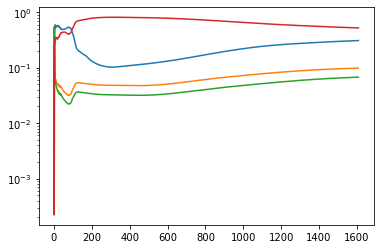

In [643]:
plt.plot(obj.stored_weights.T)
plt.yscale('log')

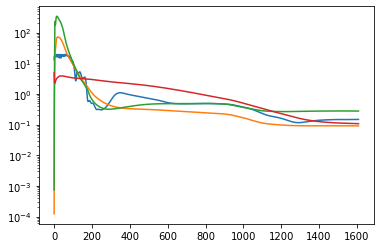

In [644]:
tmp_losses = obj.stored_losses.T
plt.plot((tmp_losses)/tmp_losses[100:].std(0))
# plt.ylim(-10,10)
plt.yscale('log')

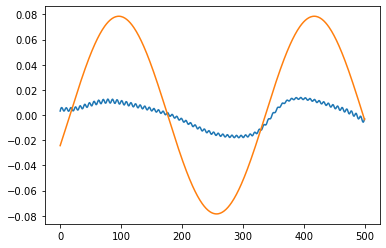

In [645]:
plt.plot(obj.pulse.detach())
plt.plot(obj.init_pulse())

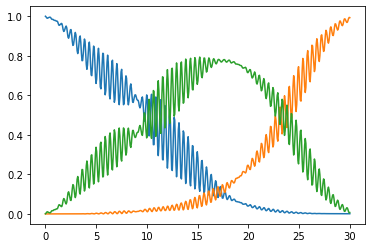

In [646]:
# obj.plot_activation_func()
obj.plot_occupancy()